<a href="https://colab.research.google.com/github/CalistDsouza/Artificial-Intelligence-with-Machine-Learning/blob/main/resnet50_car_bike_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Perform standard imports

In [ ]:
! pip install split-folders

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
!unzip /content/archive.zip -d /content/dataset

Archive:  /content/archive.zip
replace /content/dataset/Car-Bike-Dataset/Bike/Bike (1).jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Car-Bike-Dataset/Bike/Bike (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Prepare train and test sets, loaders

In [ ]:
splitfolders.ratio("/content/dataset/Car-Bike-Dataset", output="/content/dataset/Train_Test",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 4000 files [00:01, 2847.71 files/s]


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255)


test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
num_classes = 2
img_shape = (256,256,3)
batch_size = 32

In [ ]:
batch_size = 32

training_set = train_datagen.flow_from_directory('/content/dataset/Train_Test/train/',
                                                 target_size = (224,224),
                                                 class_mode='binary',
                                                 shuffle = True,
                                                 batch_size = batch_size)
test_set = train_datagen.flow_from_directory('/content/dataset/Train_Test/val/',
                                                 target_size = (224,224),
                                                 class_mode='binary',
                                                 shuffle = False,
                                                 batch_size = 1)


Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


##  Import ResNet-50

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top = False)
# setting include_top to False means the classification layers are not added and it is only a feature extracter and we will add
# the clasification layers by ourself.
output = base_model.output

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │ 256)                   │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Freeze upto 143 layers

In [ ]:
for layer in base_model.layers[:143]: layer.trainable = False

In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name,"-", layer.trainable)

0 input_layer - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_con

# Early Stopping

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=5,
    verbose = 1,
    restore_best_weights=True # Restore best model weights
)

# Adding more layers to base model

In [ ]:
model = Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D()) # For Flattening
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Training and Testing the model

In [ ]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9) ,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(training_set, epochs = 500,  validation_data = test_set, callbacks = [early_stop])

Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 356ms/step - accuracy: 0.8268 - loss: 0.4158 - val_accuracy: 0.7375 - val_loss: 0.4810
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.9161 - loss: 0.2091 - val_accuracy: 0.9000 - val_loss: 0.2619
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.9279 - loss: 0.1688 - val_accuracy: 0.9312 - val_loss: 0.1672
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.9364 - loss: 0.1608 - val_accuracy: 0.9425 - val_loss: 0.1355
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.9634 - loss: 0.0953 - val_accuracy: 0.8925 - val_loss: 0.2794
Epoch 6/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.9673 - loss: 0.0773 - val_accuracy: 0.9413 - val_loss: 0.1580
Epoch 7/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.9711 - loss: 0.0824 - val_accuracy: 0.9125 - val_loss: 0.2394
Epoch 8/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - accuracy: 0.9700 -

In [ ]:
loss, acc = model.evaluate(test_set)
loss, acc

800/800 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9315 - loss: 0.1534


(0.13545754551887512, 0.9424999952316284)

In [ ]:
trainAcc = [100 * x for x in history.history['accuracy']]
testAcc = [100 * x for x in history.history['val_accuracy']]

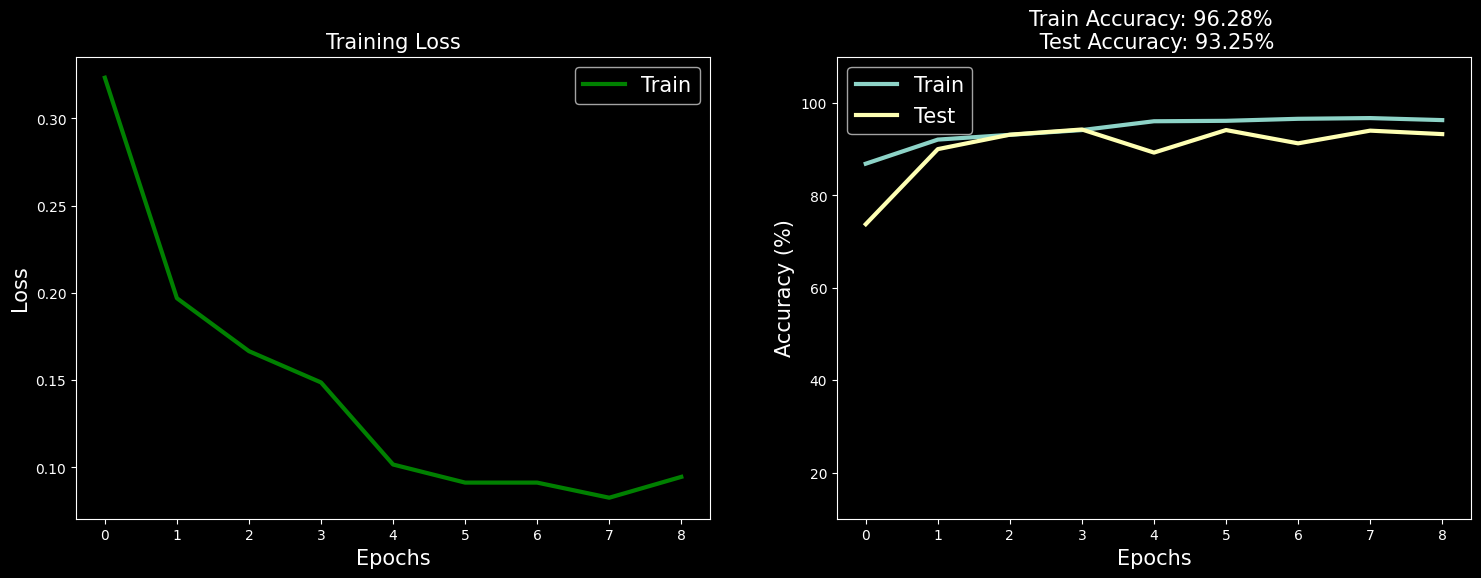

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(history.history['loss'], 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)


ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

In [ ]:
images, labels = next(training_set)

class_names = list(training_set.class_indices.keys())

predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


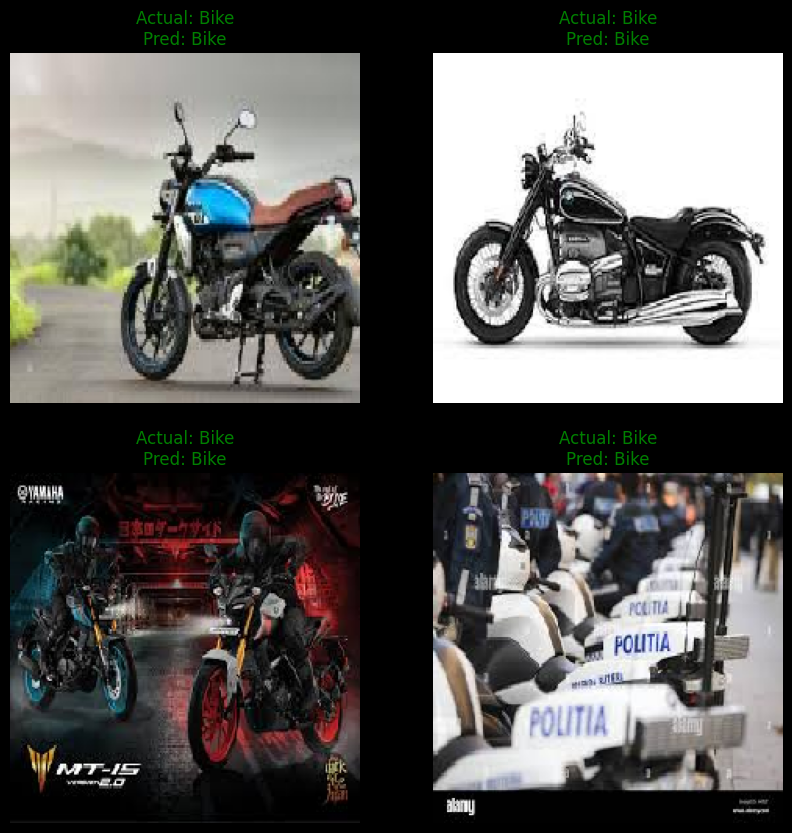

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    true_label = class_names[int(labels[i])]
    pred_label = class_names[int(predicted_labels[i])]
    plt.title(f"Actual: {true_label}\nPred: {pred_label}", color="green" if true_label == pred_label else "red")
    plt.axis("off")

plt.show()